# **How often are appointments missed in the SNEE footprint?**

- This is required so that we can model the number of appointments missed, as this will require the patient to re-attend in the model at a later date.

- Are SNEE sub-ICB missed appointments greater than the national average (in FY 2022)?

- [using multiple years] Are the missed appointment %ages consistent over time (compare years, statistical tests)?

- Across staff groups & Sub-ICB, are some appointments more likely to be missed?

- Using the analysis from the above, what is the mean likelihood that someone (from a combination of)
    - Sub-ICB
    - Staff type
    - Appointment type
    - Will not attend?

- Suggest an appropriate distribution to sample from, to determine if a patient with the above appointment will attend.
Persist the distribution information from 5. to a yaml file.

prove andrew wrong - he believes NOrth east essex people do not attend appointments more as compared ot other two

### **Importing libraries**

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from schemas import DataCatalog
import constants as const
import seaborn as sns

### **Loading the catalog**

In [60]:
catalog =  DataCatalog.load_from_yaml("data_catalog.yaml")

### **Loading the dataset 'NHS GP Appointments by Region' for appointments data**

In [61]:
gp_appts_catalog_entry = catalog.single_data_sources[0]
gp_appts_df = gp_appts_catalog_entry.load()
print(gp_appts_catalog_entry.zip_file.namelist())

#Combining data for all the ICB's
dfs = []
for ccg_name in gp_appts_catalog_entry.zip_file.namelist():
    gp_appts_catalog_entry.csv_file = ccg_name
    dfs.append(gp_appts_catalog_entry.load())

combined_df = pd.concat(dfs, axis=0)
combined_df.head()

['Regional_CSV_WYorks.csv', 'Regional_CSV_Sussex.csv', 'Regional_CSV_SurreyHearts.csv', 'Regional_CSV_SuffolkNEEssex.csv', 'Regional_CSV_StaffsStoke.csv', 'Regional_CSV_Somerset.csv', 'Regional_CSV_ShropsTelfordWrekin.csv', 'Regional_CSV_SYorks.csv', 'Regional_CSV_SWLondon.csv', 'Regional_CSV_SELondon.csv', 'Regional_CSV_NottinghamNotts.csv', 'Regional_CSV_Northamptonshire.csv', 'Regional_CSV_NorfolkWaveney.csv', 'Regional_CSV_NWLondon.csv', 'Regional_CSV_NENCumbria.csv', 'Regional_CSV_NELondon.csv', 'Regional_CSV_NCLondon.csv', 'Regional_CSV_MidSEssex.csv', 'Regional_CSV_Lincolnshire.csv', 'Regional_CSV_LeicesterLshire.csv', 'Regional_CSV_LancsSCumbria.csv', 'Regional_CSV_KentMedway.csv', 'Regional_CSV_HumberNYorks.csv', 'Regional_CSV_HertfordshireWEssex.csv', 'Regional_CSV_HereWorcs.csv', 'Regional_CSV_HampshireIoW.csv', 'Regional_CSV_Gloucestershire.csv', 'Regional_CSV_GManchesterHSCP.csv', 'Regional_CSV_FrimleyHealth.csv', 'Regional_CSV_Dorset.csv', 'Regional_CSV_Devon.csv', 'Regio

,SUB_ICB_LOCATION_CODE,SUB_ICB_LOCATION_ONS_CODE,SUB_ICB_LOCATION_NAME,ICB_ONS_CODE,ICB_NAME,REGION_ONS_CODE,REGION_NAME,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS
0,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,1 Day,1999
1,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,15 to 21 Days,329
2,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,2 to 7 Days,4194
3,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,22 to 28 Days,212
4,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,8 to 14 Days,1101


In [62]:
combined_df['APPT_MODE'].unique()

array(['Face-to-Face', 'Home Visit', 'Telephone', 'Video/Online',
       'Unknown'], dtype=object)

#### **Data pre-processing**
1. Removing un-necessary columns and making a copy  
   
2. Changing APPOINTMENT_MONTH to FY_YEAR  
  
**Note: (FY2023 only from april to august)**

In [63]:
combined_df['APPOINTMENT_MONTH'].unique()

array(['MAR2021', 'APR2021', 'MAY2021', 'JUN2021', 'JUL2021', 'AUG2021',
       'SEP2021', 'OCT2021', 'NOV2021', 'DEC2021', 'JAN2022', 'FEB2022',
       'MAR2022', 'APR2022', 'MAY2022', 'JUN2022', 'JUL2022', 'AUG2022',
       'SEP2022', 'OCT2022', 'NOV2022', 'DEC2022', 'JAN2023', 'FEB2023',
       'MAR2023', 'APR2023', 'MAY2023', 'JUN2023', 'JUL2023', 'AUG2023'],
      dtype=object)

In [64]:
needed_cols = ['ICB_NAME','SUB_ICB_LOCATION_NAME','SUB_ICB_LOCATION_ONS_CODE','APPOINTMENT_MONTH','APPT_STATUS','HCP_TYPE','APPT_MODE','COUNT_OF_APPOINTMENTS']

combined_df_copy = combined_df[needed_cols].copy()

#Replacing months values to FY- years
combined_df_copy['APPOINTMENT_MONTH'] = combined_df_copy['APPOINTMENT_MONTH'].replace({'APR2021':'FY2021', 'MAY2021':'FY2021', 'JUN2021':'FY2021', 'JUL2021':'FY2021', 'AUG2021':'FY2021', 'SEP2021':'FY2021',
                                                                                       'OCT2021':'FY2021', 'NOV2021':'FY2021', 'DEC2021':'FY2021', 'JAN2022':'FY2021', 'FEB2022':'FY2021', 'MAR2022':'FY2021',
                                                                                       'APR2022':'FY2022', 'MAY2022':'FY2022', 'JUN2022':'FY2022', 'JUL2022':'FY2022', 'AUG2022':'FY2022', 'SEP2022':'FY2022',
                                                                                       'OCT2022':'FY2022', 'NOV2022':'FY2022', 'DEC2022':'FY2022', 'JAN2023':'FY2022', 'FEB2023':'FY2022', 'MAR2023':'FY2022',
                                                                                       'APR2023':'FY2023', 'MAY2023':'FY2023', 'JUN2023':'FY2023', 'JUL2023':'FY2023', 'AUG2023':'FY2023'})

combined_df_copy = combined_df_copy.loc[combined_df_copy['APPOINTMENT_MONTH']!='MAR2021'].rename(columns={'APPOINTMENT_MONTH':'FY_YEAR'})
combined_df_copy['FY_YEAR'].unique()

array(['FY2021', 'FY2022', 'FY2023'], dtype=object)

### **Creating separate DF's for attended and not attended appointments**

In [65]:
attended_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_NAME','SUB_ICB_LOCATION_ONS_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','FY_YEAR']).mean().round(4)
attended_df.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                       
NHS Bath and North East Somerset, Swindon and W... FY2021               6441.2406
                                                   FY2022               6409.7105
                                                   FY2023               5193.6111
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021               6031.7656
                                                   FY2022               6074.6977

In [66]:
do_not_attend_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] != 'Attended'].drop(columns=['SUB_ICB_LOCATION_NAME','SUB_ICB_LOCATION_ONS_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','FY_YEAR']).mean().round(4)
do_not_attend_df.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                       
NHS Bath and North East Somerset, Swindon and W... FY2021                327.0419
                                                   FY2022                294.0753
                                                   FY2023                281.0080
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021                280.9590
                                                   FY2022                311.2077

### **Comparing the National average with SNEE**

#### **1. Attended appointments**

In [67]:
National_average_attended = attended_df['COUNT_OF_APPOINTMENTS'].mean().round(4)
National_average_attended_2022 = attended_df.loc[slice(None),'FY2022',:].mean().round(4)

SNEE_average_attended = attended_df.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'The national average for attended appointments for FY2021-22-23 is: {National_average_attended}')
print(f'The SNEE average for attended appointments for FY2021-22-23 is: {SNEE_average_attended.mean()}')
print(f'The national average for attended appointments for FY2022 is: {National_average_attended_2022}')

SNEE_average_attended

The national average for attended appointments for FY2021-22-23 is: 4414.3347
The SNEE average for attended appointments for FY2021-22-23 is: COUNT_OF_APPOINTMENTS    2067.6403
dtype: float64
The national average for attended appointments for FY2022 is: COUNT_OF_APPOINTMENTS    4763.7655
dtype: float64


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,2187.6634
FY2022,2178.0886
FY2023,1837.1689


#### **2. Not attended or unknown Appointments**

In [68]:
National_average_DNA = do_not_attend_df['COUNT_OF_APPOINTMENTS'].mean().round(4)
National_average_DNA_2022 = do_not_attend_df.loc[slice(None),'FY2022',:].mean().round(4)

SNEE_average_DNA = do_not_attend_df.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'The National average for did not attend or unknown appointments for FY2021-22-23 is: {National_average_DNA}')
print(f'The SNEE average for did not attend or unknown appointments for FY2021-22-23 is: {SNEE_average_DNA.mean()}')
print(f'The National average for did not attend or unknown appointments for FY2022 is: {National_average_DNA_2022}')

SNEE_average_DNA

The National average for did not attend or unknown appointments for FY2021-22-23 is: 259.9349
The SNEE average for did not attend or unknown appointments for FY2021-22-23 is: COUNT_OF_APPOINTMENTS    100.102
dtype: float64
The National average for did not attend or unknown appointments for FY2022 is: COUNT_OF_APPOINTMENTS    277.7867
dtype: float64


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,97.5304
FY2022,101.0678
FY2023,101.7078


- We can see that the overall average for non-attended appointments for SNEE-ICB is 100, which is much lesser than National Average of 260
  
- For year 2022, this difference increases as the National average increases from 260 to 277, whereas for SNEE-ICB the change is from 100 to 101

### **Plotting the attended and non-attended lineplot**

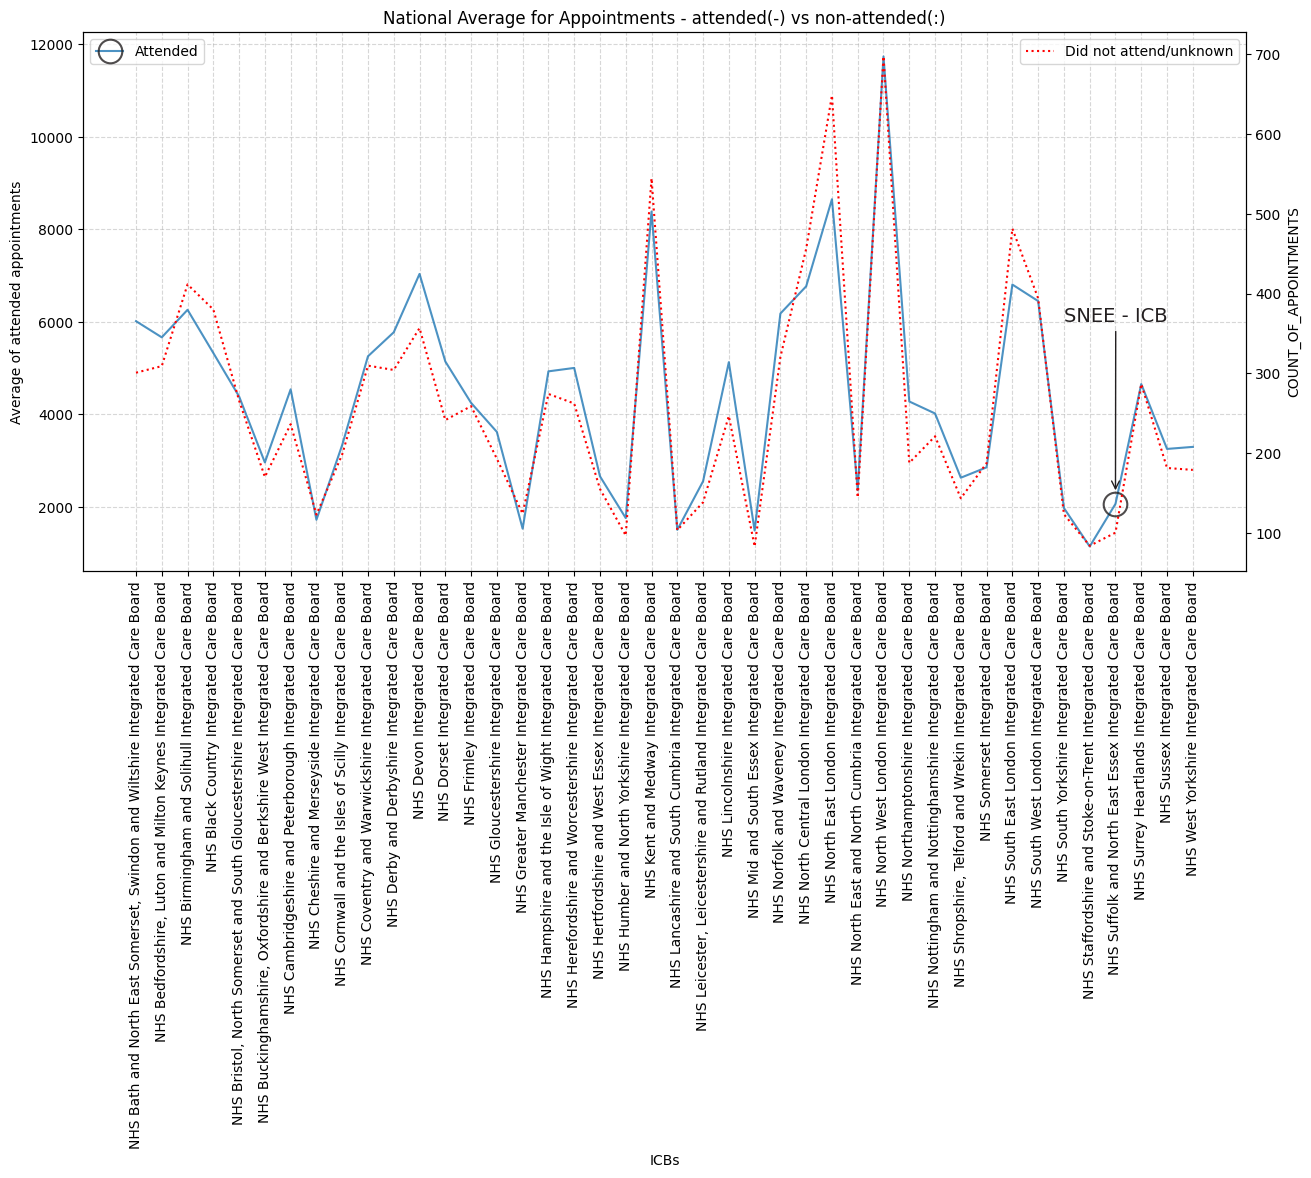

In [69]:
attended_df2 = attended_df.groupby('ICB_NAME').mean().reset_index()
do_not_attend_df2 = do_not_attend_df.groupby('ICB_NAME').mean().reset_index()

snee = 'NHS Suffolk and North East Essex Integrated Care Board'
#Plotting the lineplot
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
plt.xlabel('ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylabel('Average of attended appointments')
plt.title('National Average for Appointments - attended(-) vs non-attended(:)')
ax = sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=attended_df2, label = 'Attended', alpha=0.8, marker = 'o', markersize=17, fillstyle='none', markeredgewidth=1.5, markeredgecolor='#231f20', markevery=[38])
ax.annotate('SNEE - ICB',xy=(38,2300), xytext=(36,6000), arrowprops =dict(arrowstyle='->',color='#231f20'),color='#231f20', fontsize=14)
ax.legend(loc = 'upper left')
#Creating secondary y-axis
ax2 = ax.twinx()
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=do_not_attend_df2, color ='red', linestyle=':', ax=ax2, label = 'Did not attend/unknown')
ax2.set_label('Average of did not attend Appointments')

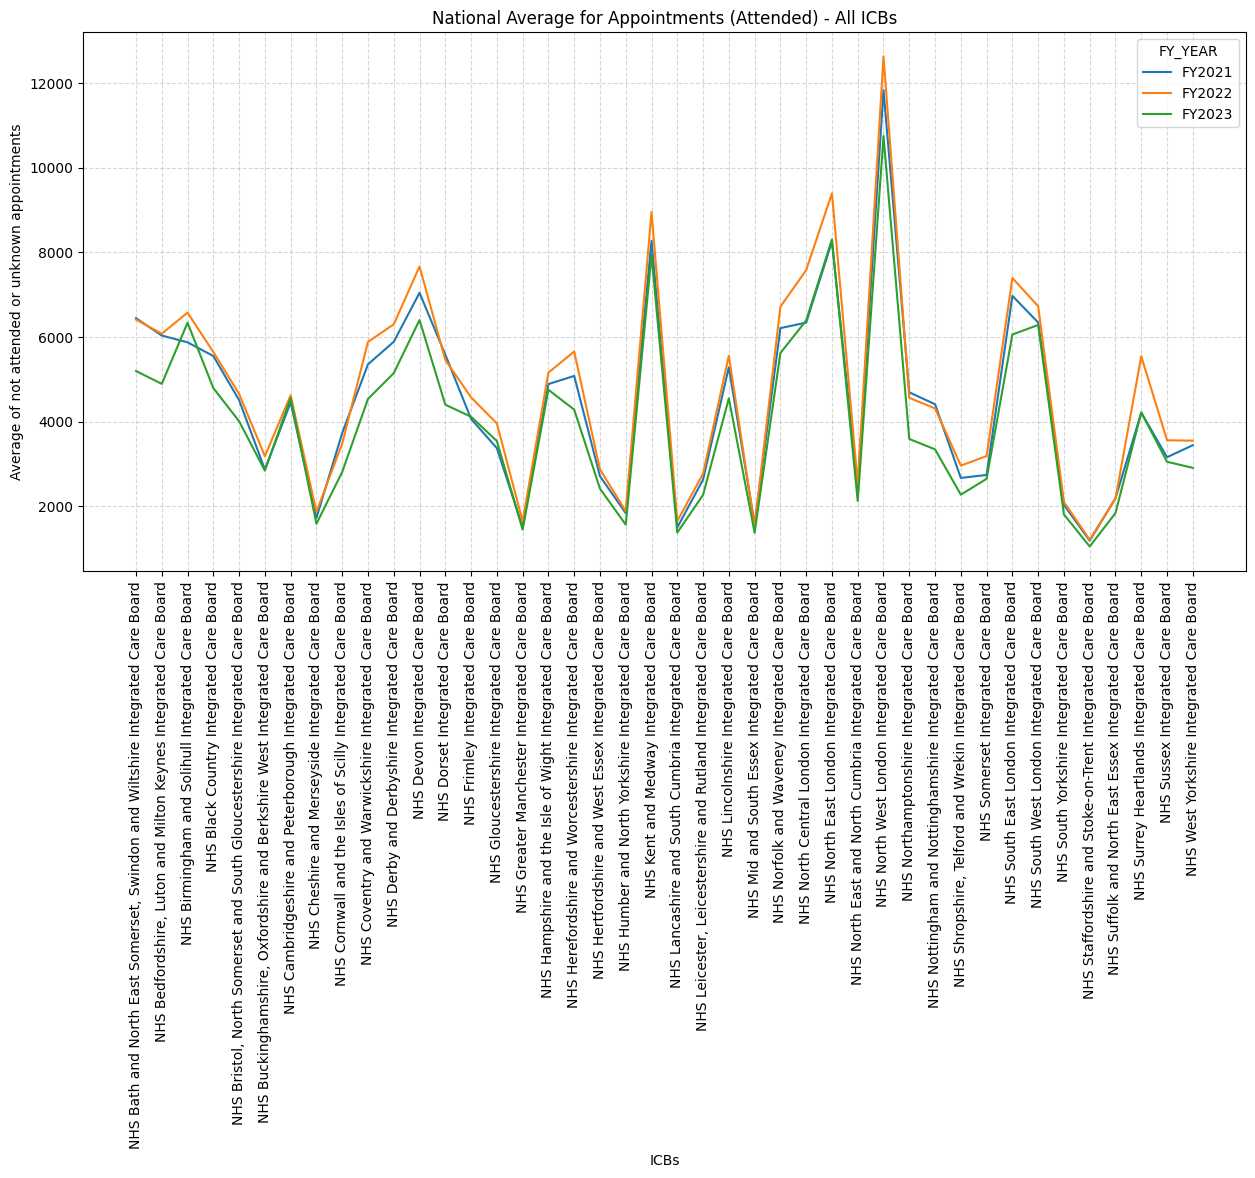

In [70]:
#Plotting the Attended appointments lineplot
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=attended_df, hue='FY_YEAR')
plt.xlabel('ICBs')
plt.ylabel('Average of not attended or unknown appointments')
plt.title('National Average for Appointments (Attended) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

#Barpolt

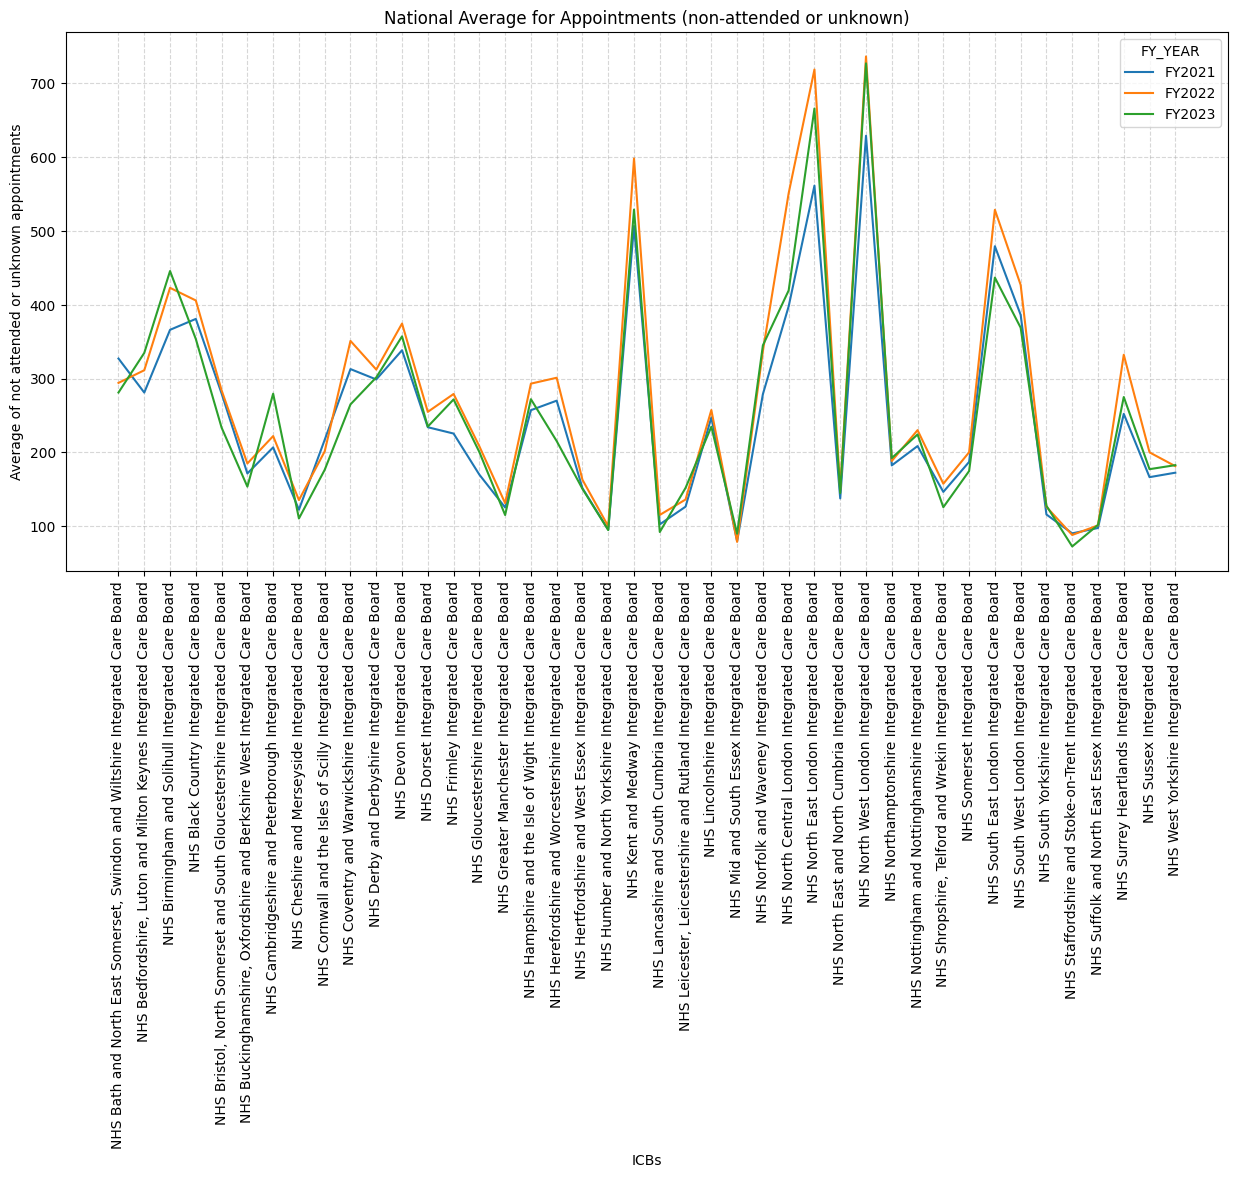

In [71]:
#Plotting the did not attended or unknown lineplpots
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=do_not_attend_df, hue='FY_YEAR')
plt.xlabel('ICBs')
plt.ylabel('Average of not attended or unknown appointments')
plt.title('National Average for Appointments (non-attended or unknown)')
plt.grid(True, linestyle='--', alpha=0.5)

## **Analysing the effect of HCP type and Appointment mode**

In [72]:
combined_df_copy['HCP_TYPE'].unique()

array(['GP', 'Other Practice staff', 'Unknown'], dtype=object)

### **Attended appointments based on Health care professional type and Appointment mode**

In [73]:
attended_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_NAME','SUB_ICB_LOCATION_ONS_CODE','APPT_STATUS','FY_YEAR']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).mean().round(4)
attended_hcptype_apptmode

COUNT_OF_APPOINTMENTS
ICB_NAME                                           HCP_TYPE APPT_MODE                          
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face             14436.9871
                                                            Home Visit                 142.7819
                                                            Telephone                11148.2478
                                                            Unknown                     23.3611
                                                            Video/Online               102.5330
...                                                                                         ...
NHS West Yorkshire Integrated Care Board           Unknown  Face-to-Face                66.9141
                                                            Home Visit                  19.0409
                                                            Telephone                  342.0952
                                                            Unknown                    915.0151
                                                            Video/Online                28.3333

[600 rows x 1 columns]

### **Did not attend appointments based on Health care professional type and Appointment mode**

In [74]:
dna_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] != 'Attended'].drop(columns=['SUB_ICB_LOCATION_NAME','SUB_ICB_LOCATION_ONS_CODE','APPT_STATUS','FY_YEAR']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).mean().round(4)
dna_hcptype_apptmode

COUNT_OF_APPOINTMENTS
ICB_NAME                                           HCP_TYPE APPT_MODE                          
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face               400.4009
                                                            Home Visit                   3.5130
                                                            Telephone                  110.4186
                                                            Unknown                     22.2632
                                                            Video/Online                 4.0056
...                                                                                         ...
NHS West Yorkshire Integrated Care Board           Unknown  Face-to-Face                15.5203
                                                            Home Visit                   7.4491
                                                            Telephone                    9.7985
                                                            Unknown                     54.2481
                                                            Video/Online                11.0000

[605 rows x 1 columns]

In [75]:
#Calculating National average for GP's for DNA Appointments
DNA_GP_f2f = dna_hcptype_apptmode.loc[(slice(None),'GP','Face-to-Face'),:].mean().round(4).item()
DNA_GP_homevisit = dna_hcptype_apptmode.loc[(slice(None),'GP','Home Visit'),:].mean().round(4).item()
DNA_GP_tel = dna_hcptype_apptmode.loc[:,'GP','Telephone'].mean().round(4).item()
DNA_GP_unknown = dna_hcptype_apptmode.loc[:,'GP','Unknown'].mean().round(4).item()
DNA_GP_video_online = dna_hcptype_apptmode.loc[:,'GP','Video/Online'].mean().round(4).item()

#Calculating National average for Other Practice staff for DNA Appointments
DNA_p_staff_f2f = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Face-to-Face'),:].mean().round(4).item()
DNA_p_staff_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Home Visit'),:].mean().round(4).item()
DNA_p_staff_tel = dna_hcptype_apptmode.loc[:,'Other Practice staff','Telephone'].mean().round(4).item()
DNA_p_staff_unknown = dna_hcptype_apptmode.loc[:,'Other Practice staff','Unknown'].mean().round(4).item()
DNA_p_staff_video_online = dna_hcptype_apptmode.loc[:,'Other Practice staff','Video/Online'].mean().round(4).item()

#Calculating National average for Unknown for DNA Appointments
DNA_unknown_f2f = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Face-to-Face'),:].mean().round(4).item()
DNA_unknown_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Home Visit'),:].mean().round(4).item()
DNA_unknown_tel = dna_hcptype_apptmode.loc[:,'Unknown','Telephone'].mean().round(4).item()
DNA_unknown_unknown = dna_hcptype_apptmode.loc[:,'Unknown','Unknown'].mean().round(4).item()
DNA_unknown_video_online = dna_hcptype_apptmode.loc[:,'Unknown','Video/Online'].mean().round(4).item()


data = {
    'GP' : [DNA_GP_f2f, DNA_GP_homevisit, DNA_GP_tel, DNA_GP_unknown, DNA_GP_video_online],
    'Practice staff' : [DNA_p_staff_f2f, DNA_p_staff_homevisit, DNA_p_staff_tel, DNA_p_staff_unknown, DNA_p_staff_video_online],
    'Unknown' : [DNA_unknown_f2f, DNA_unknown_homevisit, DNA_unknown_tel, DNA_unknown_unknown, DNA_unknown_video_online]
}

index_values = ['Face to face', 'Home visit', 'Telephone', 'Unknown', 'Video/Online']

national_average_dna_hcp_appt_type = pd.DataFrame(data, index=index_values)
national_average_dna_hcp_appt_type

,GP,Practice staff,Unknown
Face to face,481.1398,1189.0332,45.5460
Home visit,23.5635,20.9361,17.4643
Telephone,262.1513,188.4992,29.4066
Unknown,33.5371,68.0858,99.9015
Video/Online,22.1635,22.6973,15.5319


In [76]:
dna_hcptype_apptmode.loc['NHS Suffolk and North East Essex Integrated Care Board',:,:].T

HCP_TYPE                        GP                                             \
APPT_MODE             Face-to-Face Home Visit Telephone  Unknown Video/Online   
COUNT_OF_APPOINTMENTS     116.7975     3.8492    43.872  12.1083       9.2624   

HCP_TYPE              Other Practice staff                                \
APPT_MODE                     Face-to-Face Home Visit Telephone  Unknown   
COUNT_OF_APPOINTMENTS             478.3423     5.6865   49.5093  28.0617   

HCP_TYPE                                Unknown                                
APPT_MODE             Video/Online Face-to-Face Home Visit Telephone  Unknown  
COUNT_OF_APPOINTMENTS      12.2615      92.0052     5.9728    2.2921  36.3861

<Axes: >

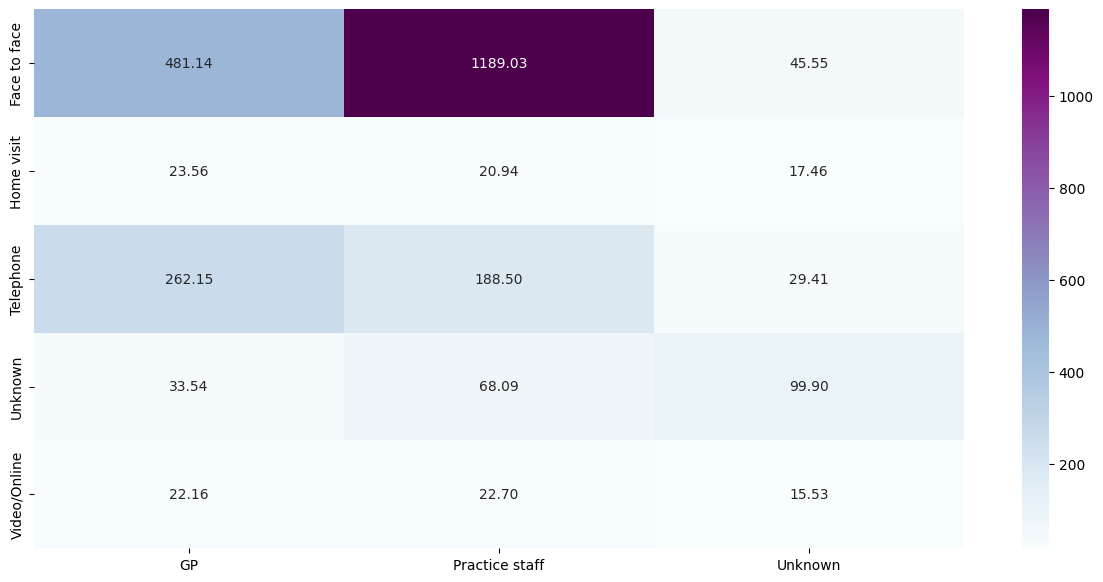

In [77]:
plt.subplots(figsize=(15,7))
sns.heatmap(national_average_dna_hcp_appt_type, annot=True, fmt='.2f', cmap='BuPu')

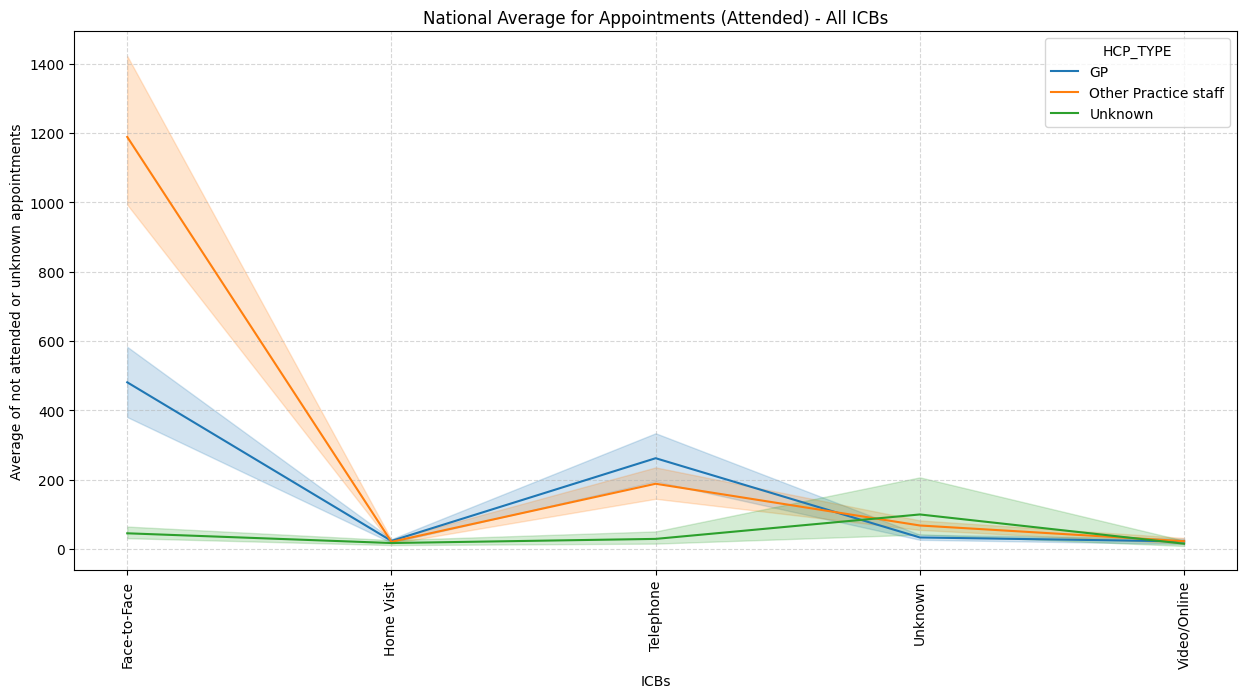

In [78]:
#Plotting the Attended appointments lineplot
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.lineplot(x='APPT_MODE', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('ICBs')
plt.ylabel('Average of not attended or unknown appointments')
plt.title('National Average for Appointments (Attended) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

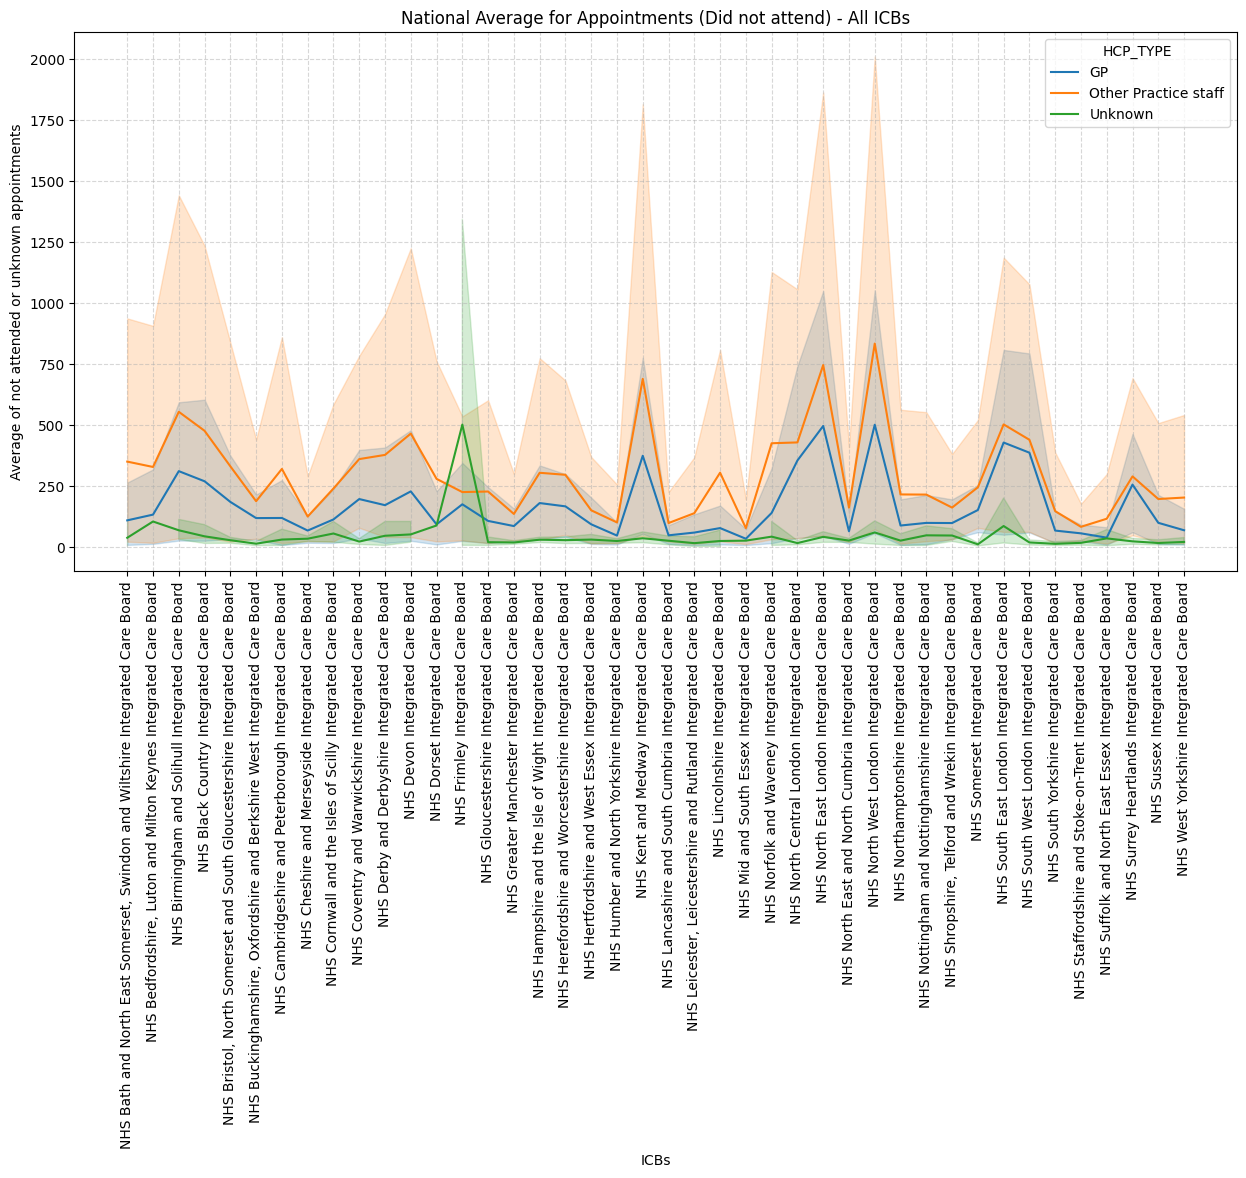

In [79]:
#Plotting the Attended appointments lineplot
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('ICBs')
plt.ylabel('Average of not attended or unknown appointments')
plt.title('National Average for Appointments (Did not attend) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

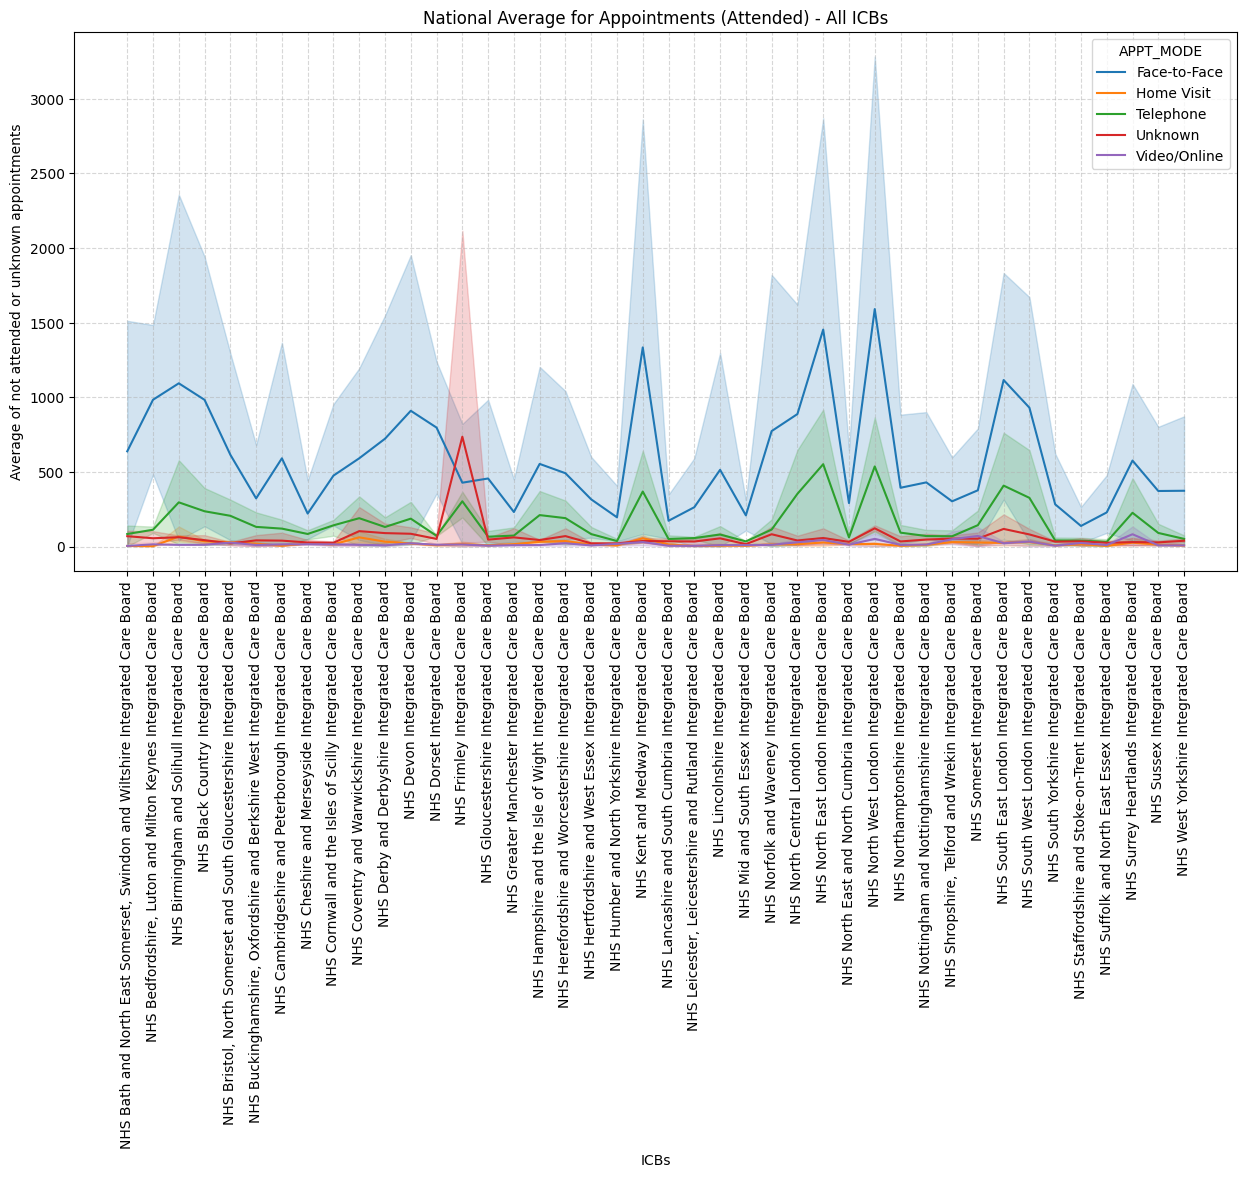

In [80]:
#Plotting the Attended appointments lineplot
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='APPT_MODE')
plt.xlabel('ICBs')
plt.ylabel('Average of not attended or unknown appointments')
plt.title('National Average for Appointments (Attended) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

## **Separate approach**

In [105]:
combined_df_2 = combined_df_copy.loc[:,['SUB_ICB_LOCATION_NAME','HCP_TYPE','APPT_MODE','APPT_STATUS','COUNT_OF_APPOINTMENTS','FY_YEAR']].pivot_table(index=['SUB_ICB_LOCATION_NAME','HCP_TYPE','APPT_MODE','FY_YEAR'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

sum_row = combined_df_2.sum(axis=1)
combined_df_2 = combined_df_2.div(sum_row, axis=0)*100
combined_df_2

COUNT_OF_APPOINTMENTS  \
APPT_STATUS                                                                                   Attended   
SUB_ICB_LOCATION_NAME                              HCP_TYPE APPT_MODE    FY_YEAR                         
NHS Bath and North East Somerset Swindon and Wi... GP       Face-to-Face FY2021              95.485783   
                                                                         FY2022              95.485204   
                                                                         FY2023              93.195754   
                                                            Home Visit   FY2021              94.723969   
                                                                         FY2022              96.491228   
...                                                                                                ...   
NHS West Yorkshire ICB - X2C4Y                     Unknown  Face-to-Face FY2021              99.456522   
                                                                         FY2022                    NaN   
                                                            Unknown      FY2021              89.345778   
                                                                         FY2022              88.608142   
                                                                         FY2023              88.166040   

                                                                                            \
APPT_STATUS                                                                            DNA   
SUB_ICB_LOCATION_NAME                              HCP_TYPE APPT_MODE    FY_YEAR             
NHS Bath and North East Somerset Swindon and Wi... GP       Face-to-Face FY2021   2.096193   
                                                                         FY2022   2.369269   
                                                                         FY2023   2.505296   
                                                            Home Visit   FY2021   2.480783   
                                                                         FY2022   1.682778   
...                                                                                    ...   
NHS West Yorkshire ICB - X2C4Y                     Unknown  Face-to-Face FY2021        NaN   
                                                                         FY2022        NaN   
                                                            Unknown      FY2021   2.918405   
                                                                         FY2022   3.069003   
                                                                         FY2023   2.371214   

                                                                                              
APPT_STATUS                                                                          Unknown  
SUB_ICB_LOCATION_NAME                              HCP_TYPE APPT_MODE    FY_YEAR              
NHS Bath and North East Somerset Swindon and Wi... GP       Face-to-Face FY2021     2.418024  
                                                                         FY2022     2.145526  
                                                                         FY2023     4.298949  
                                                            Home Visit   FY2021     2.795248  
                                                                         FY2022     1.825994  
...                                                                                      ...  
NHS West Yorkshire ICB - X2C4Y                     Unknown  Face-to-Face FY2021     0.543478  
                                                                         FY2022   100.000000  
                                                            Unknown      FY2021     7.735817  
                                                                         FY2022     8.322854  
                                            

In [107]:
combined_df_2 = combined_df_2.reset_index()

In [113]:
#combined_df_2.columns = combined_df_2.columns.droplevel(0)
combined_df_2.columns

Index(['', '', '', '', 'Attended', 'DNA', 'Unknown'], dtype='object', name='APPT_STATUS')

In [114]:
combined_df_2

APPT_STATUS,,,,,Attended,DNA,Unknown
0,NHS Bath and North East Somerset Swindon and W...,GP,Face-to-Face,FY2021,95.485783,2.096193,2.418024
1,NHS Bath and North East Somerset Swindon and W...,GP,Face-to-Face,FY2022,95.485204,2.369269,2.145526
2,NHS Bath and North East Somerset Swindon and W...,GP,Face-to-Face,FY2023,93.195754,2.505296,4.298949
3,NHS Bath and North East Somerset Swindon and W...,GP,Home Visit,FY2021,94.723969,2.480783,2.795248
4,NHS Bath and North East Somerset Swindon and W...,GP,Home Visit,FY2022,96.491228,1.682778,1.825994
...,...,...,...,...,...,...,...
3968,NHS West Yorkshire ICB - X2C4Y,Unknown,Face-to-Face,FY2021,99.456522,NaN,0.543478
3969,NHS West Yorkshire ICB - X2C4Y,Unknown,Face-to-Face,FY2022,NaN,NaN,100.000000
3970,NHS West Yorkshire ICB - X2C4Y,Unknown,Unknown,FY2021,89.345778,2.918405,7.735817
3971,NHS West Yorkshire ICB - X2C4Y,Unknown,Unknown,FY2022,88.608142,3.069003,8.322854


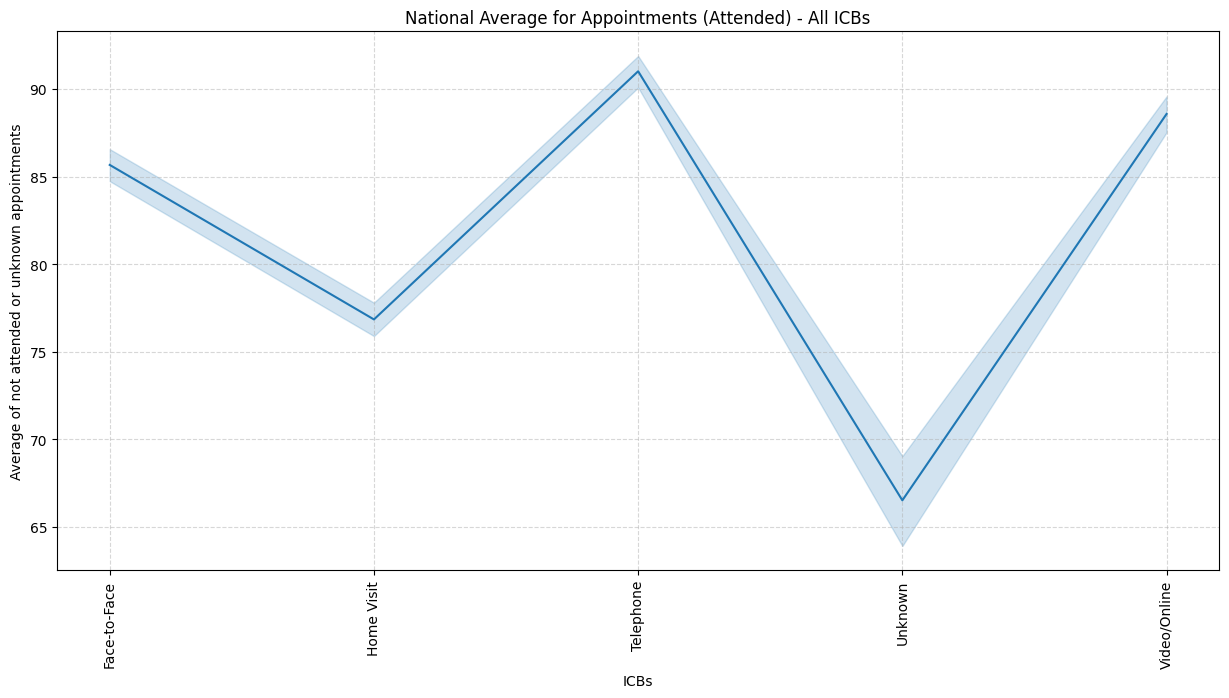

In [104]:
#Plotting the Attended appointments lineplot
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.lineplot(x='APPT_MODE', y='Attended',hue=''  data=combined_df_2)
plt.xlabel('ICBs')
plt.ylabel('Average of not attended or unknown appointments')
plt.title('National Average for Appointments (Attended) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)